Устанавливаем необходимые библиотеки

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost statsmodels numpyro jax jaxlib lifelines optuna

# Задание 1

Создайте регрессионную модель (или несколько моделей), которая описывала бы связь:


*   среднего радиуса опухоли и средней площади;
*   среднего периметра;
*   средней симметричности.

Постройте график (или графики, если моделей несколько), на котором отразите регрессионную прямую, и прокомментируйте свои находки.

Были рассмотрены несколько вариантов решения задачи:


1.   Univariate regression - целевая переменная предсказывается на основе 1 параметра
2.   Multivariate regression- целевая переменная пресдказывается на основе более 1 параметра

В качестве моделей были рассмотрены:


*   Линейная регрессия
*   Полиномиальная регрессия (2-го порядка)
*   Случайный лес
*   XGBoost
*   CatBoost
*   Байесовскую регрессию через библиотеку NumPyro

Начнем с Univariate regression


====== Linear Regression ======



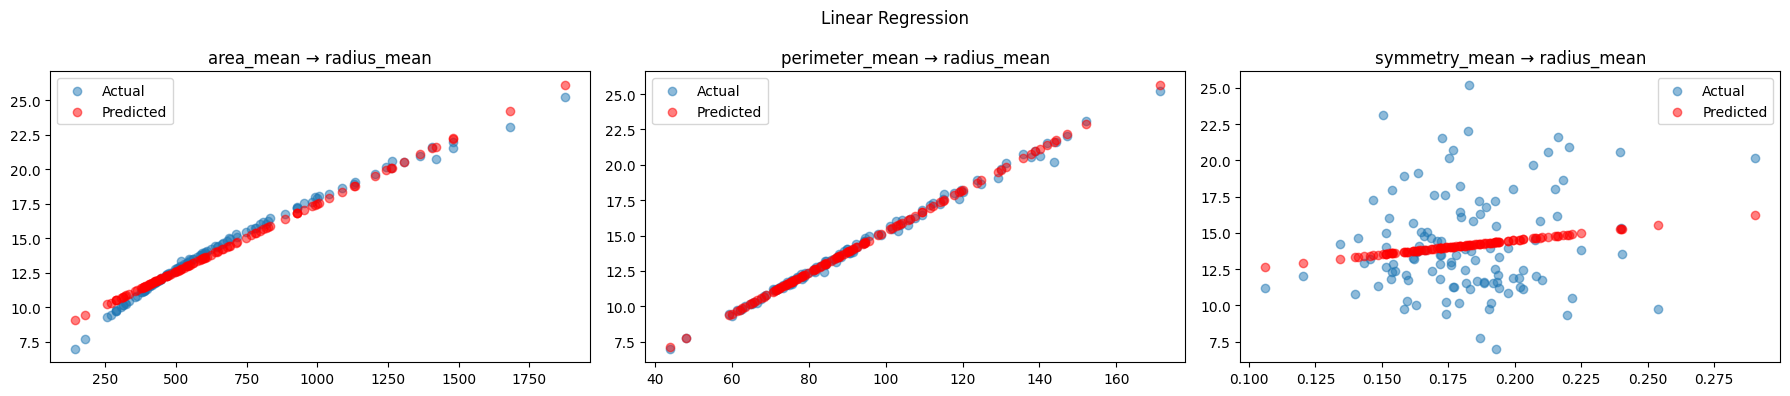


====== Polynomial Regression ======



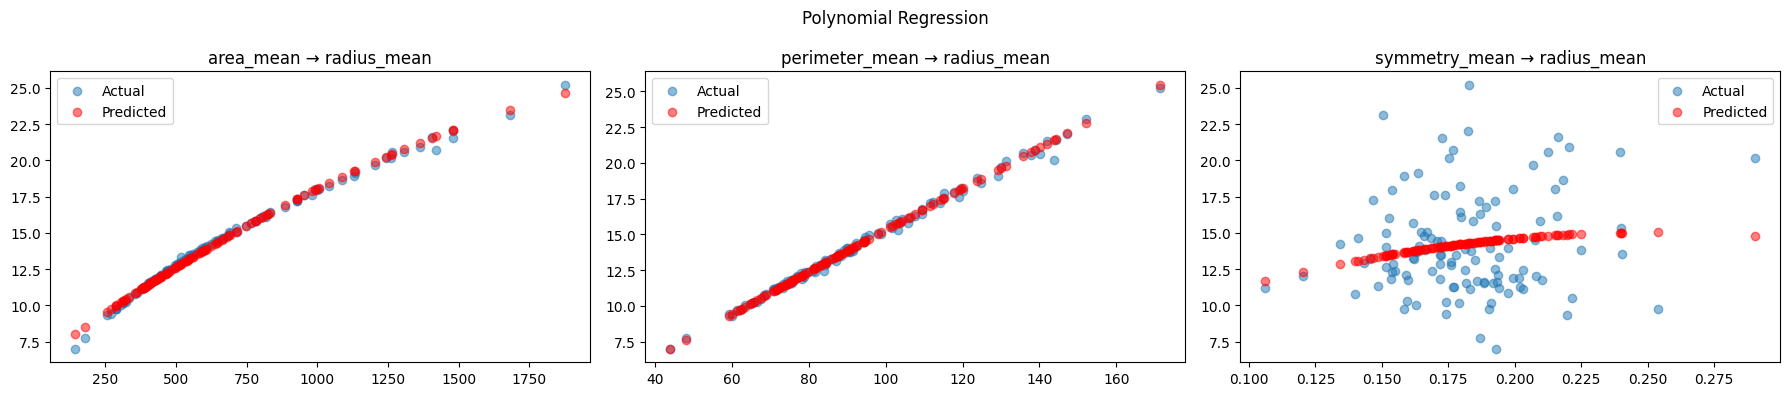


====== Random Forest ======



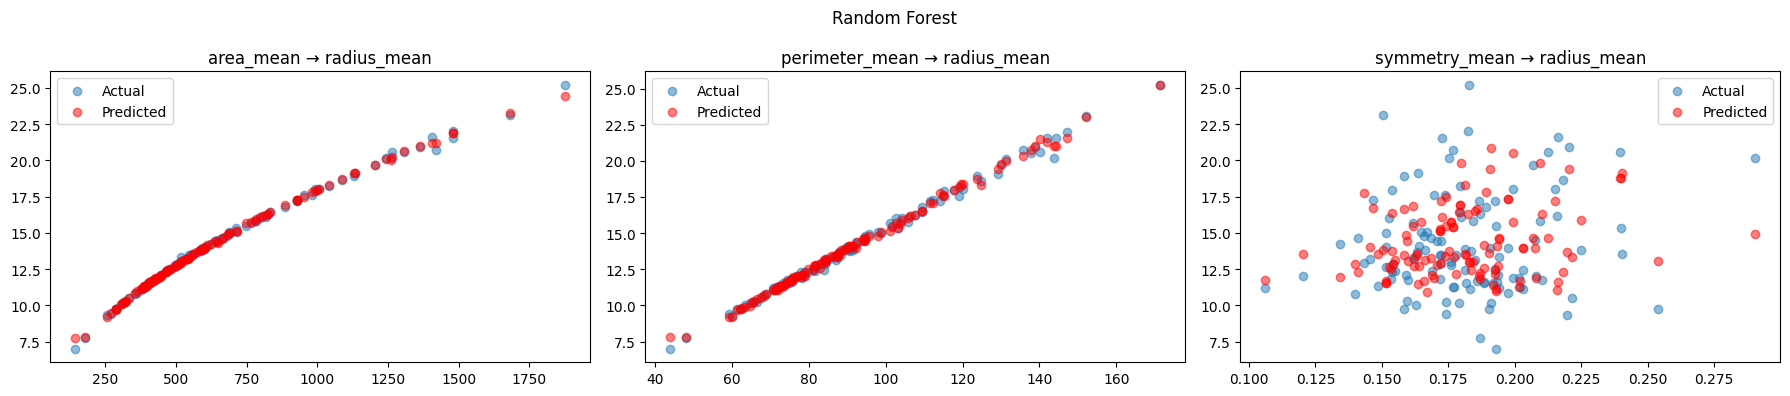


====== XGBoost ======



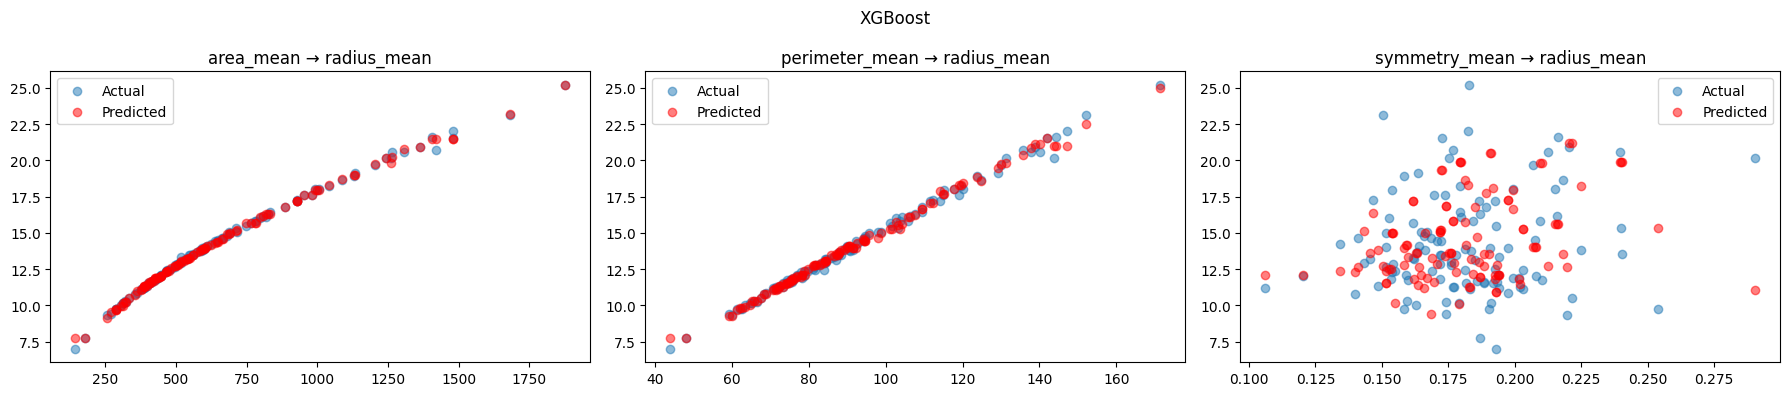


====== CatBoost ======



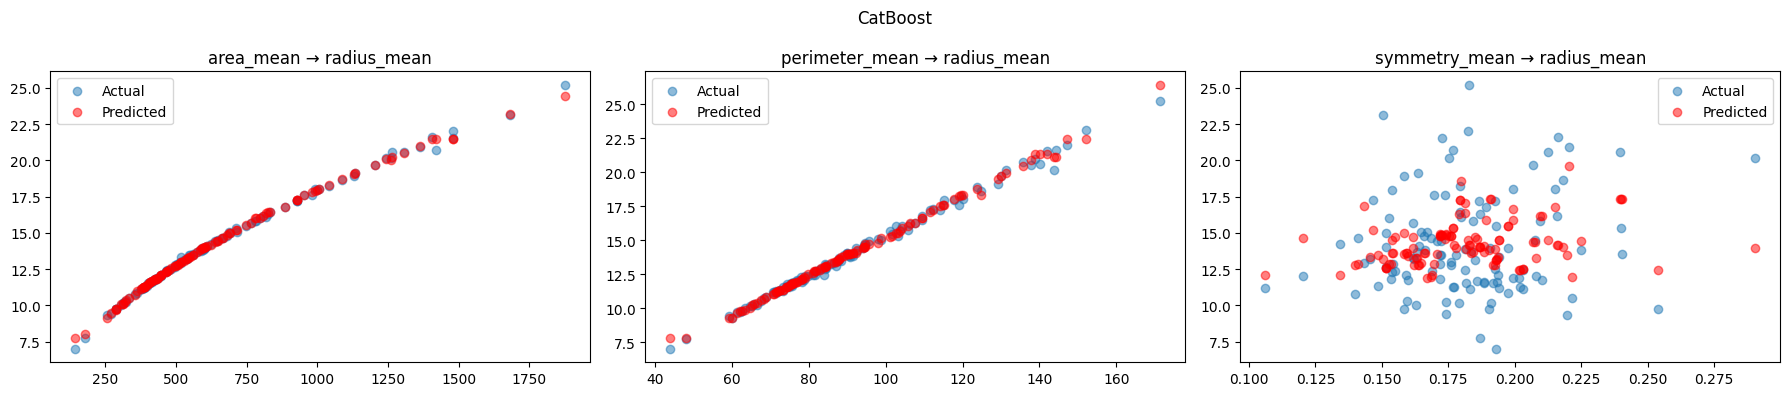


====== Quantile Regression ======



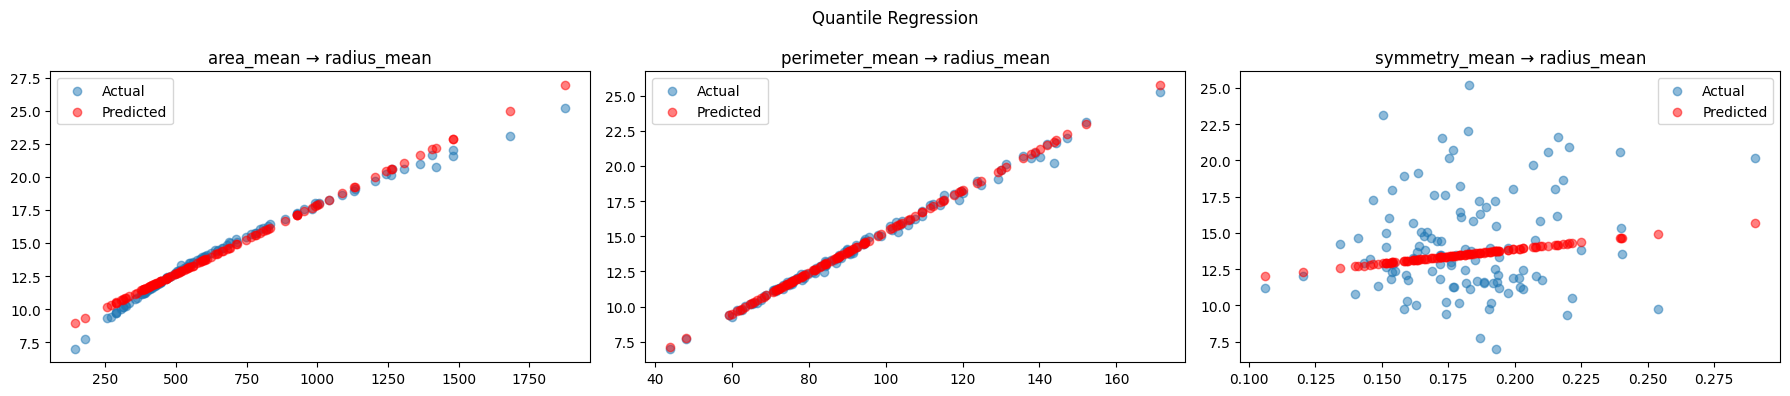


====== NumPyro Bayesian ======



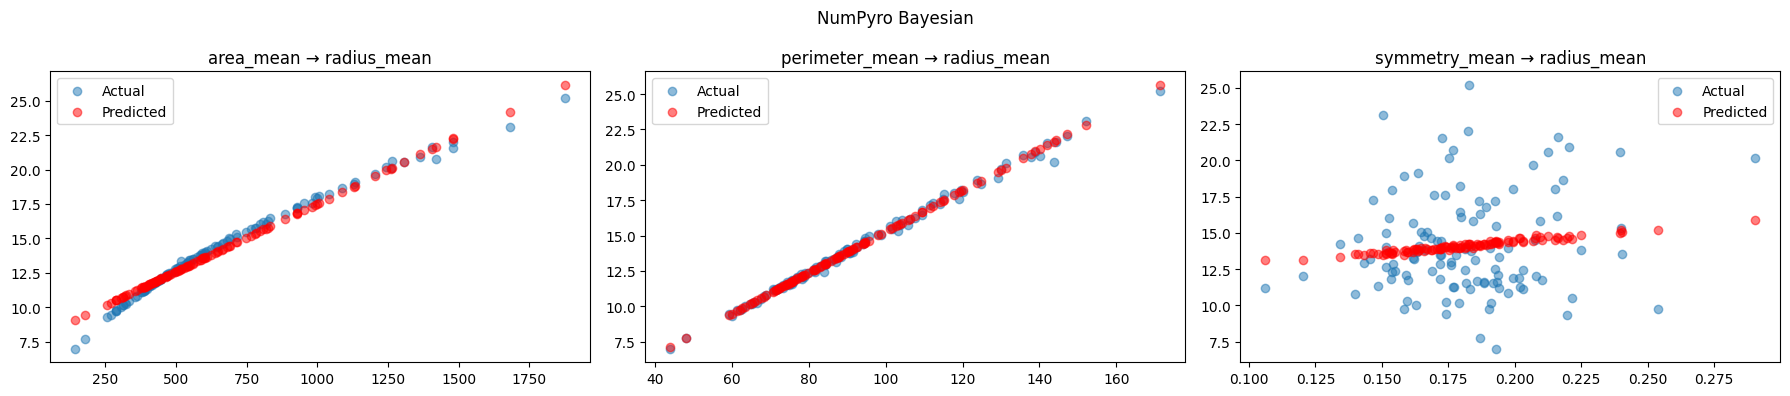


 Метрики Univariate regression:

       MAE      MSE    RMSE      R²                  Model         Feature
9   0.0875   0.0214  0.1463  0.9982                XGBoost       area_mean
6   0.0882   0.0230  0.1517  0.9981          Random Forest       area_mean
12  0.0900   0.0263  0.1620  0.9978               CatBoost       area_mean
3   0.1549   0.0503  0.2243  0.9958  Polynomial Regression       area_mean
0   0.3724   0.2324  0.4821  0.9808      Linear Regression       area_mean
18  0.3757   0.2334  0.4831  0.9807       NumPyro Bayesian       area_mean
15  0.3267   0.2454  0.4954  0.9797    Quantile Regression       area_mean
4   0.1486   0.0495  0.2225  0.9959  Polynomial Regression  perimeter_mean
1   0.1511   0.0517  0.2274  0.9957      Linear Regression  perimeter_mean
19  0.1513   0.0524  0.2289  0.9957       NumPyro Bayesian  perimeter_mean
16  0.1531   0.0569  0.2384  0.9953    Quantile Regression  perimeter_mean
7   0.1823   0.0657  0.2563  0.9946          Random Forest  perime

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import statsmodels.api as sm

import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

df = pd.read_csv("/content/wisconsin_breast_cancer.csv")
features = ["area_mean", "perimeter_mean", "symmetry_mean"]
target = "radius_mean"

model_defs = {
    "Linear Regression": lambda: LinearRegression(),
    "Polynomial Regression": lambda: make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Random Forest": lambda: RandomForestRegressor(n_estimators=100, random_state=0),
    "XGBoost": lambda: XGBRegressor(n_estimators=100, random_state=0, verbosity=0),
    "CatBoost": lambda: CatBoostRegressor(verbose=0, random_state=0),
    "Quantile Regression": "special_case",
    "NumPyro Bayesian": "special_case"
}

def numpyro_model(X, y=None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 10))
    beta = numpyro.sample("beta", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mean = alpha + beta * X.squeeze()
    numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

results = []
for model_name, model_creator in model_defs.items():
    print(f"\n====== {model_name} ======\n")
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    for i, feature in enumerate(features):
        X = df[[feature]].values.astype(np.float32)
        y = df[target].values.astype(np.float32)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model_name == "Quantile Regression":
            X_sm = sm.add_constant(X_train)
            model = sm.QuantReg(y_train, X_sm).fit(q=0.5)
            y_pred = model.predict(sm.add_constant(X_test))
        elif model_name == "NumPyro Bayesian":
            rng_key = random.PRNGKey(0)
            kernel = NUTS(numpyro_model)
            mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, progress_bar=False)
            mcmc.run(rng_key, X_train, y_train)
            posterior_samples = mcmc.get_samples()
            predictive = Predictive(numpyro_model, posterior_samples)
            preds = predictive(rng_key, X=X_test)
            y_pred = np.mean(preds["obs"], axis=0)
        else:
            model = model_creator()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        metrics = compute_metrics(y_test, y_pred)
        metrics.update({"Model": model_name, "Feature": feature})
        results.append(metrics)

        axs[i].scatter(X_test, y_test, label="Actual", alpha=0.5)
        axs[i].scatter(X_test, y_pred, color='red', label="Predicted", alpha=0.5)
        axs[i].set_title(f"{feature} → {target}")
        axs[i].legend()

    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)
print("\n Метрики Univariate regression:\n")
print(results_df.round(4).sort_values(["Feature", "R²"], ascending=[True, False]))


В подходе выше, мы пытались предсказать значение среднего радиуса опухоли, основывая на одном из 3 признаков (средняя площадь, средний периметер, средняя симметрия)

Как мы можем видеть из результатов, значения area_mean и perimeter_mean значимы связаны с целевым параметром radius_mean, все модели показали хороший результат (R^2 = в диапазоне 0.98-0.99). Данный результат вполне ожидаем, ведь параметры можено вывести один из другого, что будет показано ниже.

Однако параметр средней симметрии не имеет таких высоких значений метрик, что представляет более высокий интересс, с исследовтельской точки зрения. Лишь 3 модели смогли выйти на положительный R^2, то есть можем предсказывать целевой параметр едва чуть лучше среднего значения.

Хоть мы уже и получили хорошие результаты, для чистоты эксперимента переходим к Multivariate regression


====== Linear Regression ======



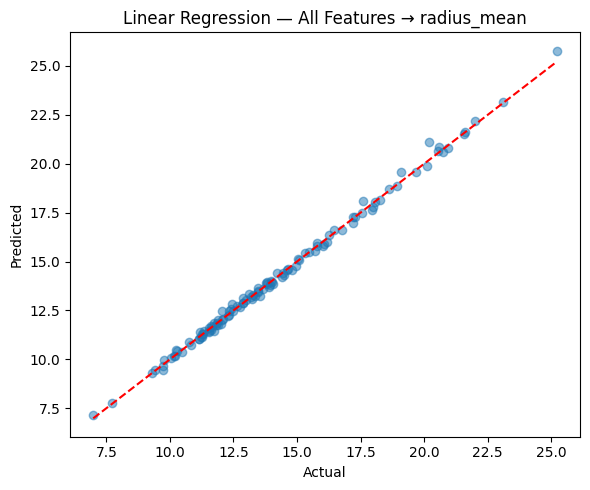


====== Polynomial Regression ======



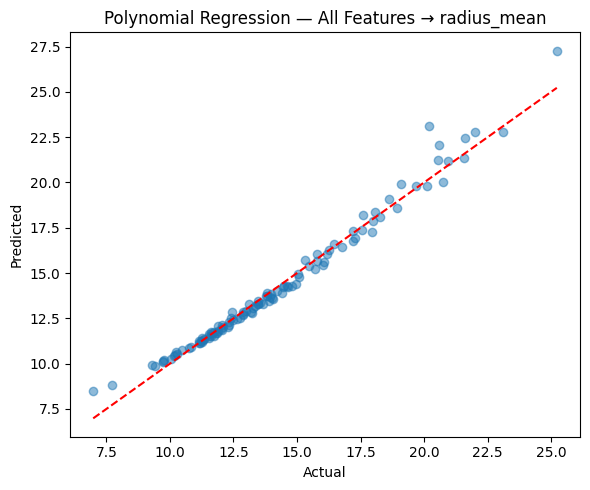


====== Random Forest ======



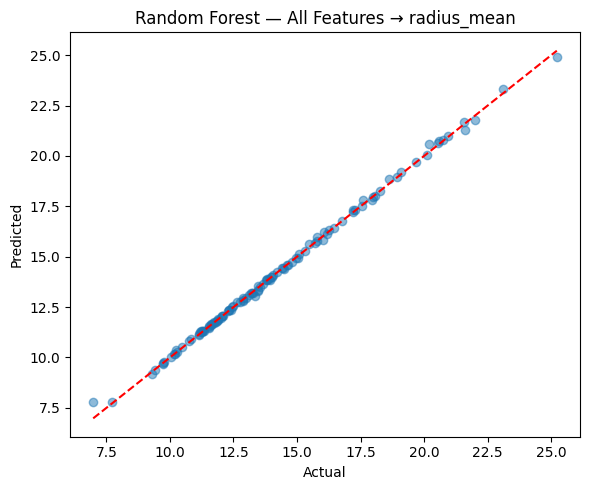


====== XGBoost ======



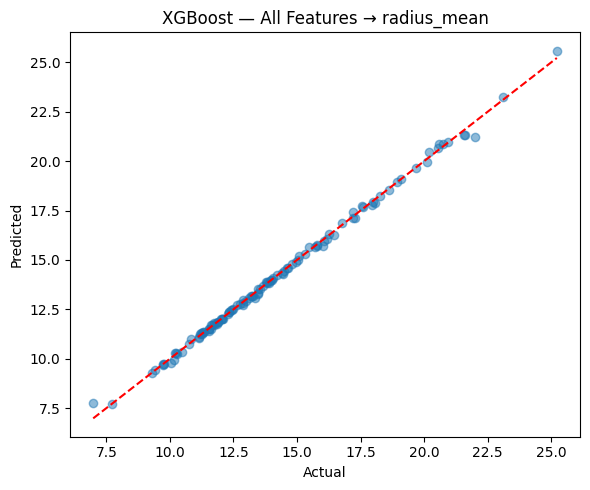


====== CatBoost ======



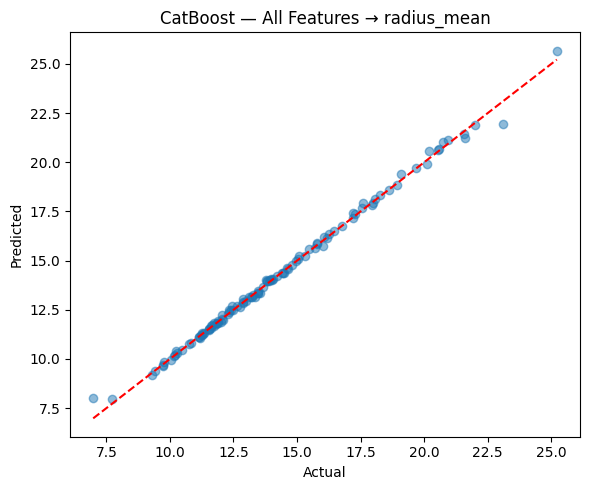


====== Quantile Regression ======



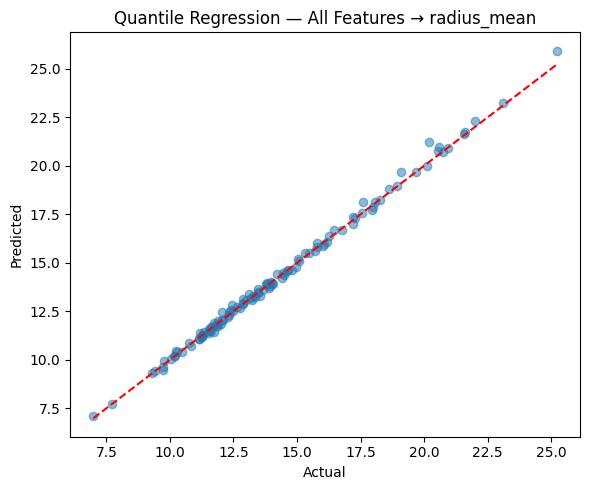


====== NumPyro Bayesian ======



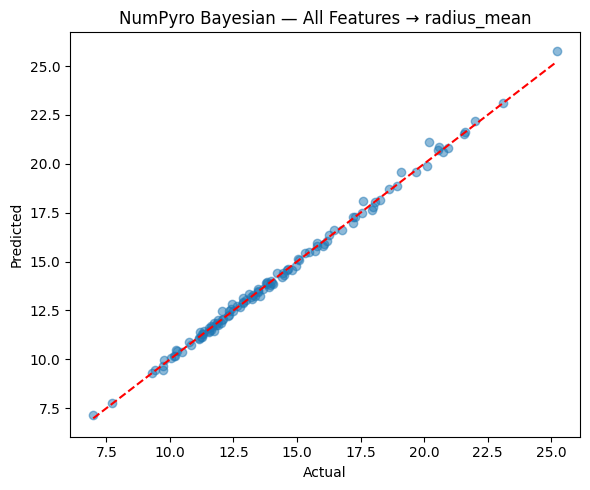


 Метрики Multivariate regression:

      MAE     MSE    RMSE      R²                  Model
2  0.0737  0.0160  0.1266  0.9987          Random Forest
3  0.0931  0.0231  0.1519  0.9981                XGBoost
0  0.1314  0.0337  0.1836  0.9972      Linear Regression
6  0.1317  0.0339  0.1841  0.9972       NumPyro Bayesian
4  0.1080  0.0370  0.1924  0.9969               CatBoost
5  0.1341  0.0390  0.1974  0.9968    Quantile Regression
1  0.3179  0.2565  0.5065  0.9788  Polynomial Regression


In [42]:

df = pd.read_csv("/content/wisconsin_breast_cancer.csv")
features = ["area_mean", "perimeter_mean", "symmetry_mean"]
target = "radius_mean"
X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

for model_name, model_creator in model_defs.items():
    print(f"\n====== {model_name} ======\n")

    if model_name == "Quantile Regression":
        X_sm = sm.add_constant(X_train)
        model = sm.QuantReg(y_train, X_sm).fit(q=0.5)
        y_pred = model.predict(sm.add_constant(X_test))
    elif model_name == "NumPyro Bayesian":
        def numpyro_multi(X, y=None):
            alpha = numpyro.sample("alpha", dist.Normal(0, 10))
            beta = numpyro.sample("beta", dist.Normal(0, 10).expand([X.shape[1]]))
            sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            mean = alpha + jnp.dot(X, beta)
            numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        rng_key = random.PRNGKey(0)
        kernel = NUTS(numpyro_multi)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, progress_bar=False)
        mcmc.run(rng_key, X_train, y_train)
        posterior_samples = mcmc.get_samples()
        predictive = Predictive(numpyro_multi, posterior_samples)
        preds = predictive(rng_key, X=X_test)
        y_pred = np.mean(preds["obs"], axis=0)
    else:
        model = model_creator()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    metrics = compute_metrics(y_test, y_pred)
    metrics["Model"] = model_name
    results.append(metrics)

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — All Features → {target}")
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)
print("\n Метрики Multivariate regression:\n")
print(results_df.round(4).sort_values("R²", ascending=False))


Как и ожидалось, если по отдельности целевой признак линейно зависим от параметров, то комбинация таких параметров, тоже будет линейна зависима. Результаты анлогичные первому варианту решения.

Как упоминалось ранее, обучаемы и целевые параметры линейно зависимы, потому что могут быть рассчитаны на основе друг друга. В таком контексте, когда есть все наборы параметров, использовать регрессионные модели нецелесообразно, ведь можно просто рассчитать параметры и получить высокую точность. Что будет показано ниже

 Расчёт radius_mean через area_mean:
MAE:  0.1451
MSE:  0.0305
RMSE: 0.1745
R²:   0.9975


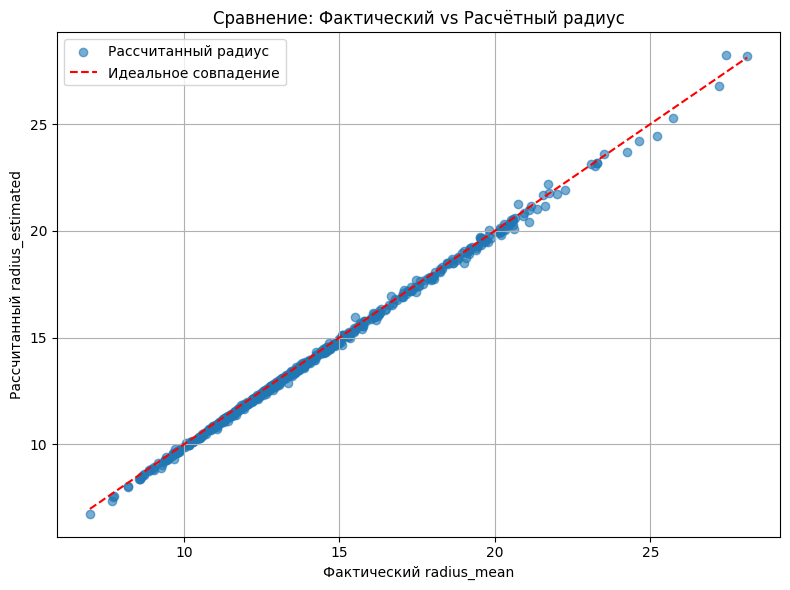

In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import pi

df = pd.read_csv("/content/wisconsin_breast_cancer.csv")

df["radius_estimated"] = np.sqrt(df["area_mean"] / pi)

y_true = df["radius_mean"]
y_pred = df["radius_estimated"]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(" Расчёт radius_mean через area_mean:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(df["radius_mean"], df["radius_estimated"], alpha=0.6, label='Рассчитанный радиус')
plt.plot([df["radius_mean"].min(), df["radius_mean"].max()],
         [df["radius_mean"].min(), df["radius_mean"].max()],
         color='red', linestyle='--', label='Идеальное совпадение')
plt.xlabel("Фактический radius_mean")
plt.ylabel("Рассчитанный radius_estimated")
plt.title("Сравнение: Фактический vs Расчётный радиус")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Мы рассчитали средний радиус через параметр area_mean и получили r^2 близкий к единицы, ч.т.д

Аналоигчным образом рассчитаем периметр, через радиус

📐 Расчёт perimeter_mean через radius_mean:
MAE:  3.2120
MSE:  17.2168
RMSE: 4.1493
R²:   0.9708


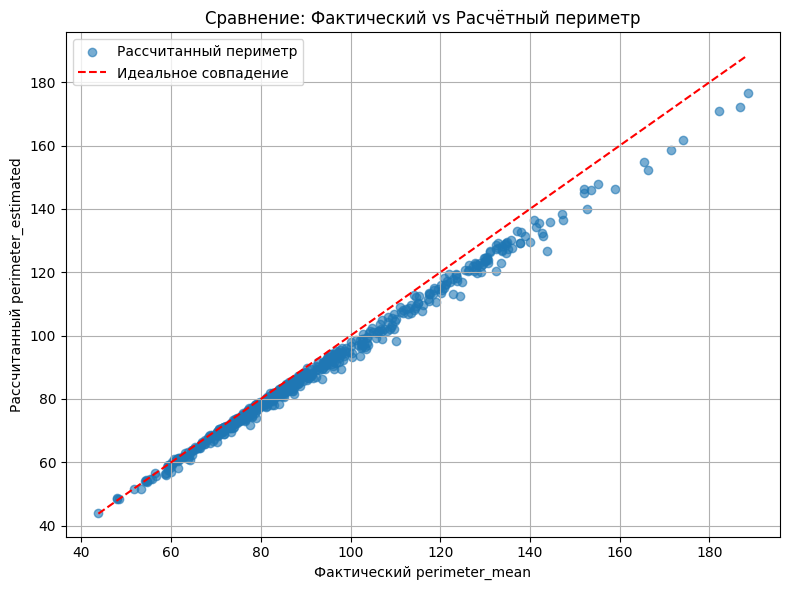

In [15]:
df["perimeter_estimated"] = 2 * pi * df["radius_mean"]

y_true = df["perimeter_mean"]
y_pred = df["perimeter_estimated"]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Вывод метрик
print(" Расчёт perimeter_mean через radius_mean:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# График
plt.figure(figsize=(8, 6))
plt.scatter(df["perimeter_mean"], df["perimeter_estimated"], alpha=0.6, label='Рассчитанный периметр')
plt.plot([df["perimeter_mean"].min(), df["perimeter_mean"].max()],
         [df["perimeter_mean"].min(), df["perimeter_mean"].max()],
         color='red', linestyle='--', label='Идеальное совпадение')
plt.xlabel("Фактический perimeter_mean")
plt.ylabel("Рассчитанный perimeter_estimated")
plt.title("Сравнение: Фактический vs Расчётный периметр")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Получили r^2 близкий к единицы, ч.т.д

Мы выяснили, что мы можем легко предсказывать и рассчитывать такие параметры как area_mean, perimeter_mean, radius_mean.

Но вспомним также, что у нас есть среднее значение симметрии, которое имеет слабую линейную зависимость с остальными рассмотренным признаками.

С исследовательской точки зрения, было бы полезно узнать, можем ли мы предсказывать это значение.
Так как из предыдущего анализа очевидно, что линейных зависимостей между параметром и остальными признаками нет, сразу перейдем к их комбинации.

Попробуем это проверить, использовав Multivariate подход


====== Linear Regression ======



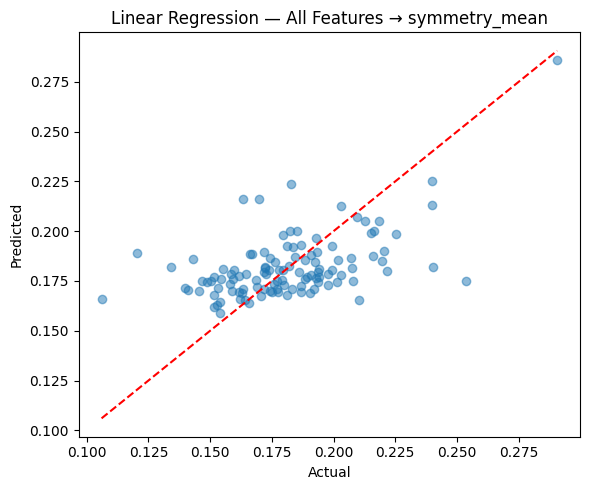


====== Polynomial Regression ======



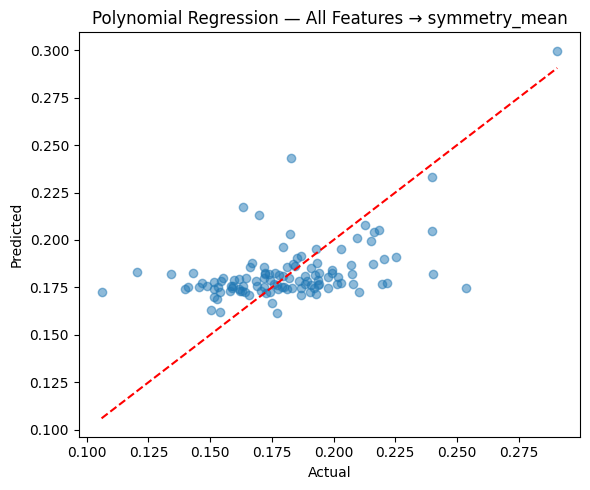


====== Random Forest ======



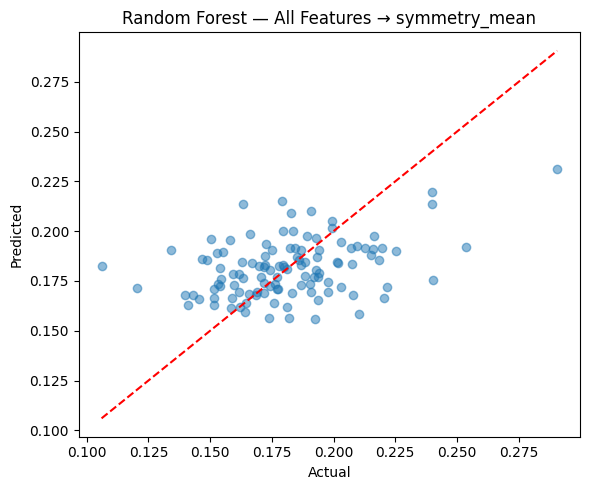


====== XGBoost ======



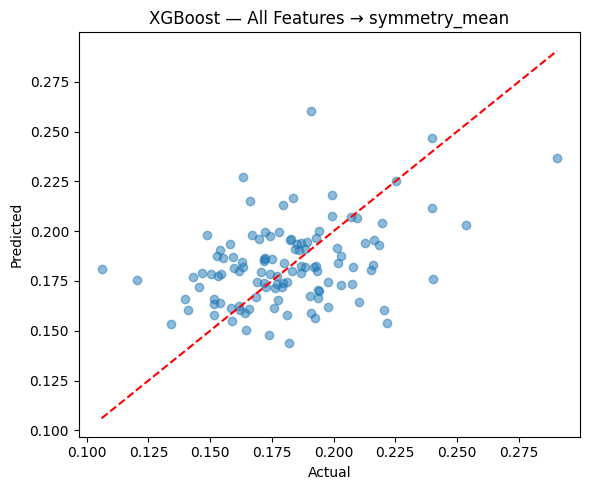


====== CatBoost ======



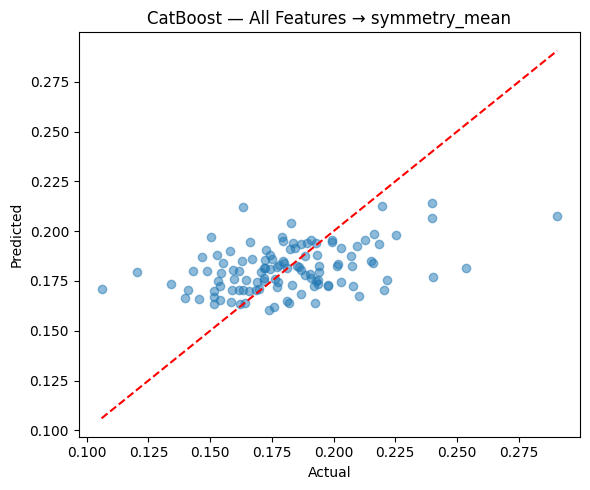


====== Quantile Regression ======



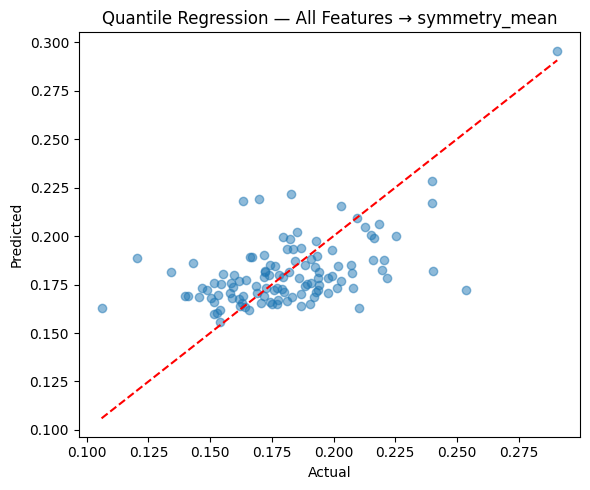


====== NumPyro Bayesian ======



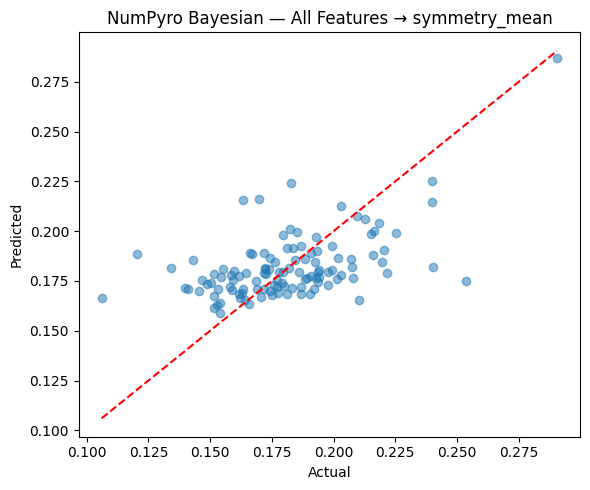


📊 Метрики Варианта 2:

      MAE     MSE    RMSE      R²                  Model
6  0.0173  0.0005  0.0227  0.2973       NumPyro Bayesian
0  0.0174  0.0005  0.0228  0.2924      Linear Regression
5  0.0176  0.0005  0.0231  0.2759    Quantile Regression
1  0.0180  0.0006  0.0236  0.2445  Polynomial Regression
4  0.0189  0.0006  0.0246  0.1748               CatBoost
2  0.0196  0.0006  0.0254  0.1254          Random Forest
3  0.0208  0.0007  0.0269  0.0172                XGBoost


In [50]:
features = ["area_mean", "perimeter_mean", "radius_mean"]
target = "symmetry_mean"
X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

for model_name, model_creator in model_defs.items():
    print(f"\n====== {model_name} ======\n")

    if model_name == "Quantile Regression":
        X_sm = sm.add_constant(X_train)
        model = sm.QuantReg(y_train, X_sm).fit(q=0.5)
        y_pred = model.predict(sm.add_constant(X_test))
    elif model_name == "NumPyro Bayesian":
        def numpyro_multi(X, y=None):
            alpha = numpyro.sample("alpha", dist.Normal(0, 10))
            beta = numpyro.sample("beta", dist.Normal(0, 10).expand([X.shape[1]]))
            sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            mean = alpha + jnp.dot(X, beta)
            numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        rng_key = random.PRNGKey(0)
        kernel = NUTS(numpyro_multi)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, progress_bar=False)
        mcmc.run(rng_key, X_train, y_train)
        posterior_samples = mcmc.get_samples()
        predictive = Predictive(numpyro_multi, posterior_samples)
        preds = predictive(rng_key, X=X_test)
        y_pred = np.mean(preds["obs"], axis=0)
    else:
        model = model_creator()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    metrics = compute_metrics(y_test, y_pred)
    metrics["Model"] = model_name
    results.append(metrics)

    # График
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — All Features → {target}")
    plt.tight_layout()
    plt.show()

# --- Метрики ---
results_df = pd.DataFrame(results)
print("\n📊 Метрики Варианта 2:\n")
print(results_df.round(4).sort_values("R²", ascending=False))

R^2 показывает, какая доля вариации целевой переменной объясняется моделью.
Мы видим что R^2 принимает "крепкое" значимое от нуля значение у ряда моделей.

NumPyro Bayesian является лучшей по всем параметрам с R^2 = 0.2973. Хотя это значение ниже, чем хотелось бы, это все равно лучший результат среди всех моделей, что означает, что модель объясняет наибольшую часть вариации данных.

Но мы пойдем дальше, и добавим в модель все данные которые у нас есть


====== Linear Regression ======



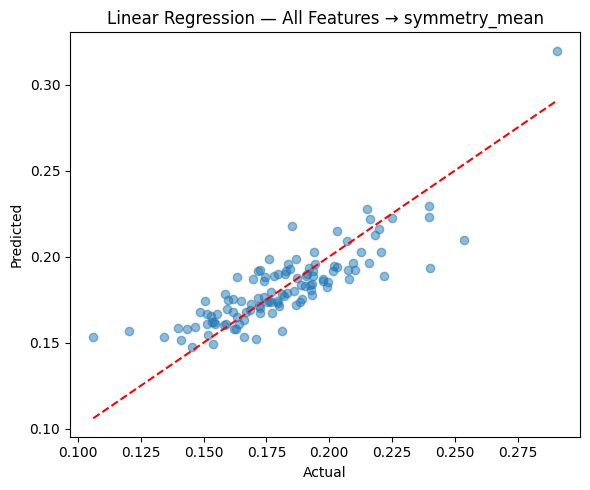


====== Polynomial Regression ======



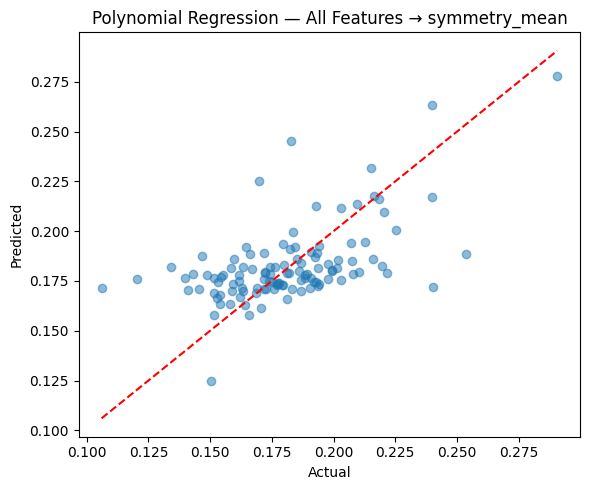


====== Random Forest ======



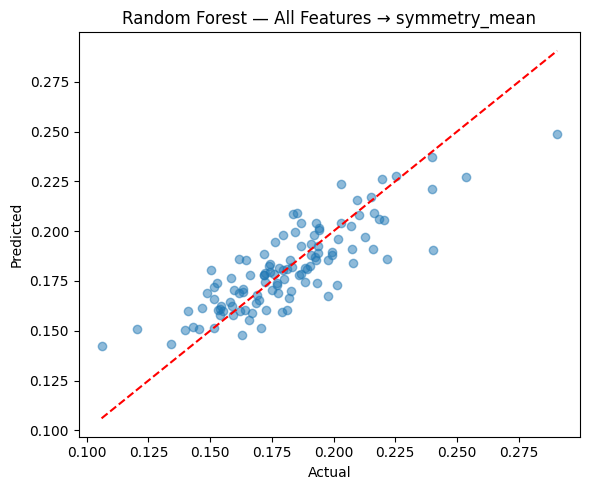


====== XGBoost ======



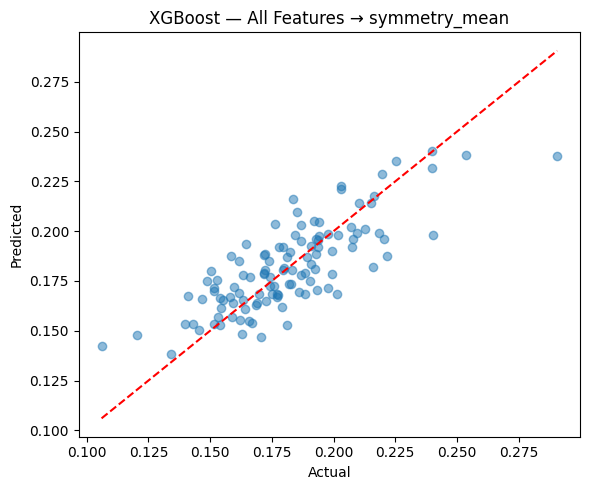


====== CatBoost ======



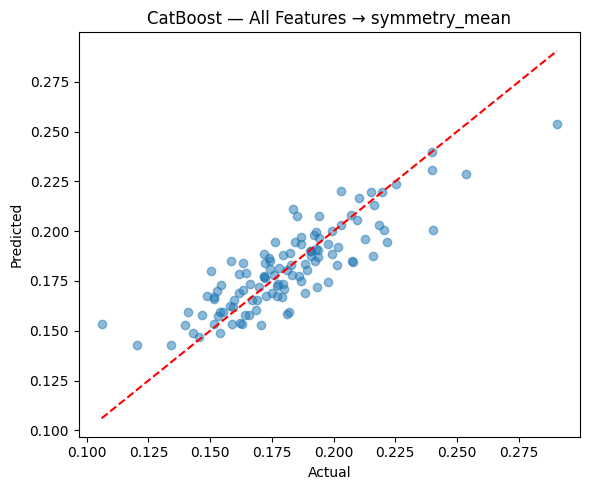


====== Quantile Regression ======



/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


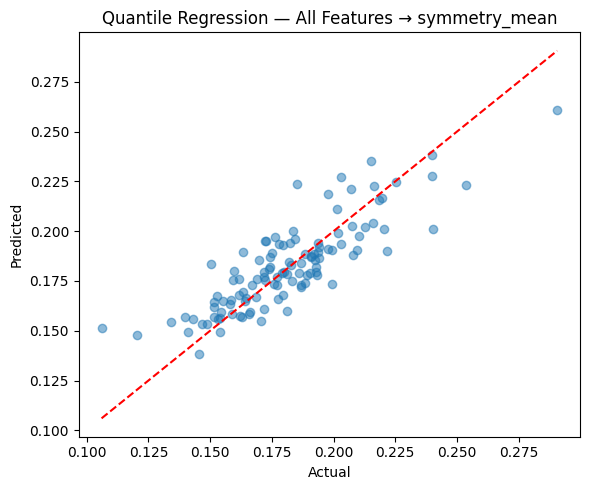


====== NumPyro Bayesian ======



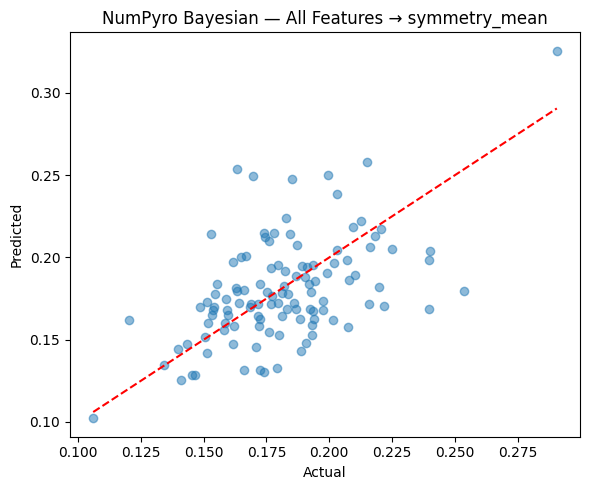

      MAE     MSE    RMSE      R²                  Model
4  0.0108  0.0002  0.0142  0.7277               CatBoost
5  0.0112  0.0002  0.0145  0.7151    Quantile Regression
0  0.0113  0.0002  0.0147  0.7058      Linear Regression
2  0.0116  0.0002  0.0150  0.6950          Random Forest
3  0.0129  0.0003  0.0164  0.6345                XGBoost
1  0.0168  0.0005  0.0224  0.3182  Polynomial Regression
6  0.0222  0.0008  0.0291 -0.1514       NumPyro Bayesian


In [51]:

saved_models = {}

df.dropna(axis=1, inplace=True)
target = "symmetry_mean"
X = df.drop(columns=['diagnosis', 'id'] + [target], axis=1).values.astype(np.float32)
y = df[target].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

for model_name, model_creator in model_defs.items():
    print(f"\n====== {model_name} ======\n")

    if model_name == "Quantile Regression":
        X_sm = sm.add_constant(X_train)
        model = sm.QuantReg(y_train, X_sm).fit(q=0.5)
        y_pred = model.predict(sm.add_constant(X_test))
    elif model_name == "NumPyro Bayesian":
        def numpyro_multi(X, y=None):
            alpha = numpyro.sample("alpha", dist.Normal(0, 10))
            beta = numpyro.sample("beta", dist.Normal(0, 10).expand([X.shape[1]]))
            sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            mean = alpha + jnp.dot(X, beta)
            numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        rng_key = random.PRNGKey(0)
        kernel = NUTS(numpyro_multi)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, progress_bar=False)
        mcmc.run(rng_key, X_train, y_train)
        posterior_samples = mcmc.get_samples()
        predictive = Predictive(numpyro_multi, posterior_samples)
        preds = predictive(rng_key, X=X_test)
        y_pred = np.mean(preds["obs"], axis=0)
    else:
        model = model_creator()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Сохраняем модель в словарь
    saved_models[model_name] = model

    metrics = compute_metrics(y_test, y_pred)
    metrics["Model"] = model_name
    results.append(metrics)

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — All Features → {target}")
    plt.tight_layout()
    plt.show()

# В конце можно проверить метрики
results_df = pd.DataFrame(results)
print(results_df.round(4).sort_values("R²", ascending=False))


Добавив остальные данные нам удалось довольно сильно улучшить наши предсказания. Но теперь возникает логичный вопрос, какие данные повлияли на улучшение результата. Это можно проверить.

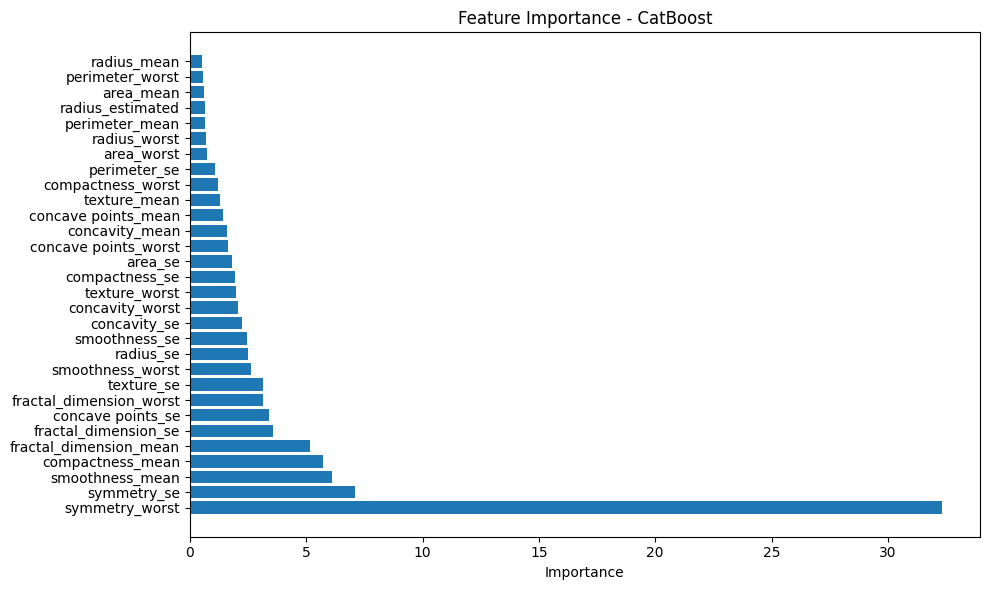

In [48]:

catboost_model = saved_models['CatBoost']

# Получаем важность признаков
importances = catboost_model.get_feature_importance()

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': df.drop(columns=['diagnosis', 'id'] + [target], axis=1).columns,
    'Importance': importances
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - CatBoost')
plt.tight_layout()
plt.show()


Мы получили очень важную информацию о том, что есть некий признак symmetry_worst, который очень сильно вляет на целевую переменную. Из названия можно сделать предположение, что это некий коэффициент отклонения от, что напрямую влияет на симметричность или асимметричность. Поэтому было бы честно и правильно, удалить этот признак, чтобы понять, сможем ли мы на основе других параметров, предсказать среднюю симметрию.


====== Linear Regression ======



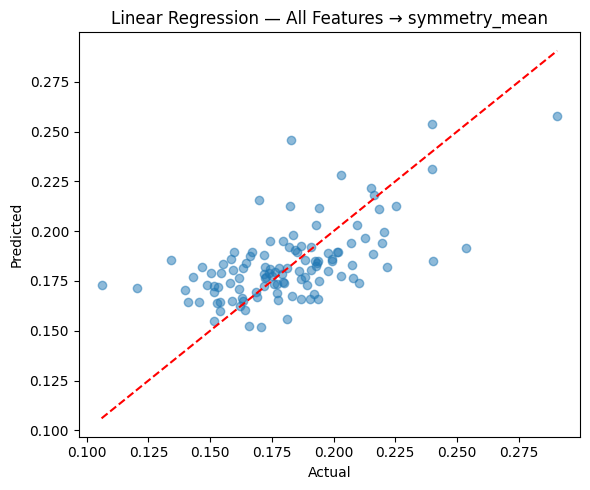


====== Polynomial Regression ======



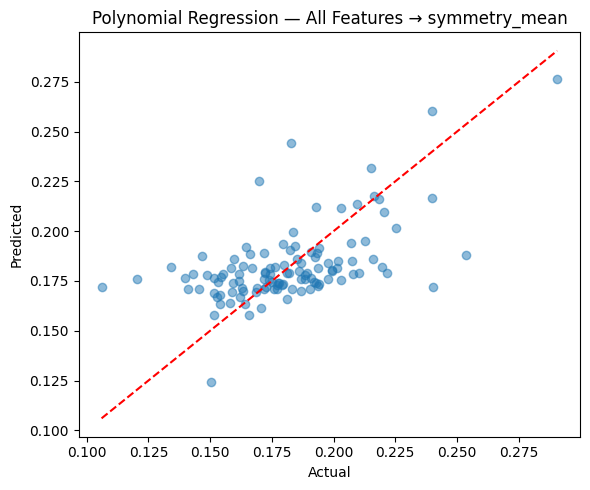


====== Random Forest ======



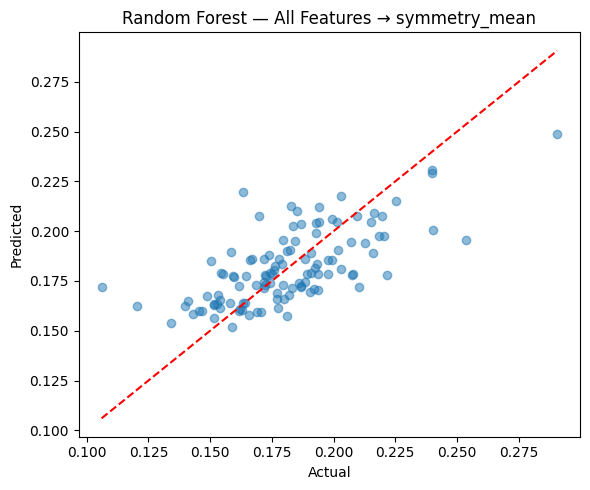


====== XGBoost ======



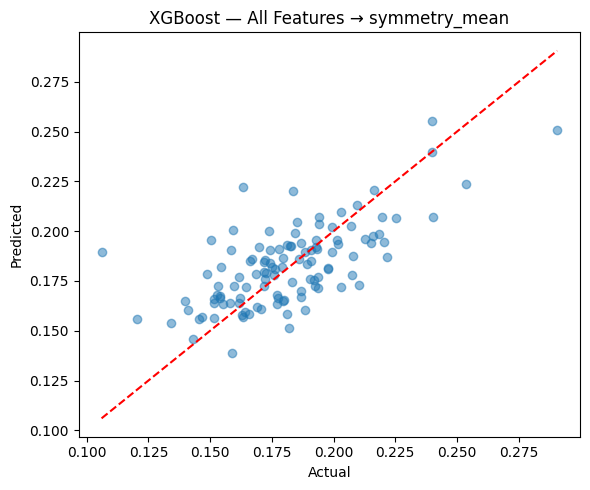


====== CatBoost ======



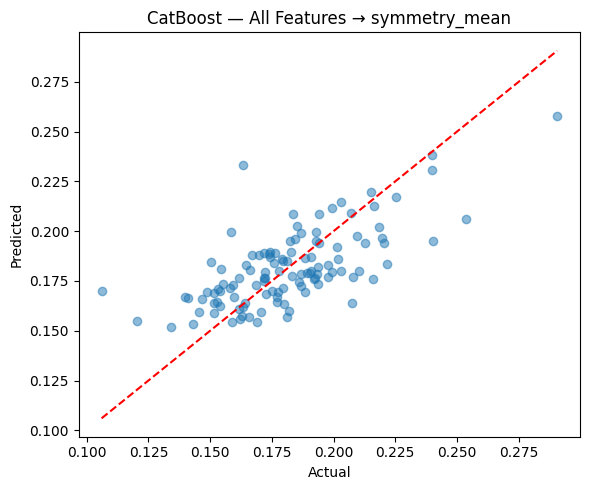


====== Quantile Regression ======



/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


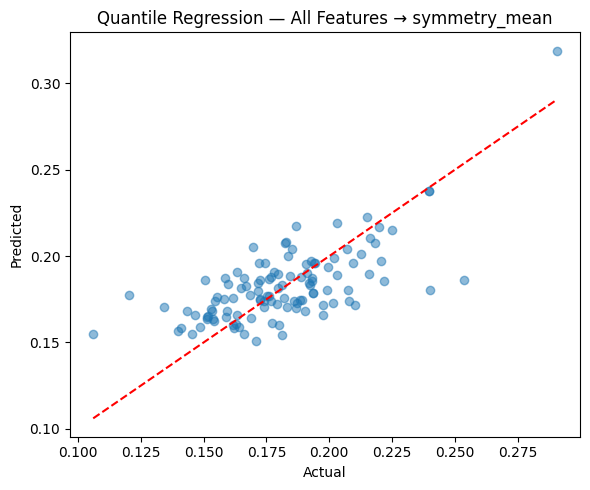


====== NumPyro Bayesian ======



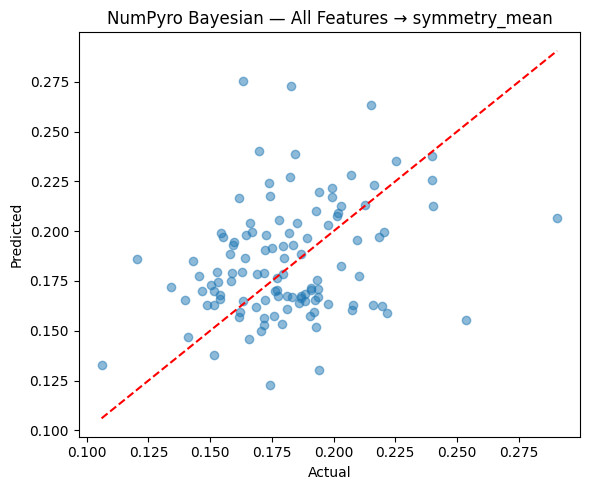

      MAE     MSE    RMSE      R²                  Model
2  0.0154  0.0004  0.0196  0.4771          Random Forest
4  0.0155  0.0004  0.0197  0.4707               CatBoost
5  0.0154  0.0004  0.0199  0.4602    Quantile Regression
3  0.0155  0.0004  0.0200  0.4540                XGBoost
0  0.0169  0.0005  0.0219  0.3468      Linear Regression
1  0.0169  0.0005  0.0224  0.3162  Polynomial Regression
6  0.0262  0.0011  0.0333 -0.5111       NumPyro Bayesian


In [52]:

saved_models = {}

df.dropna(axis=1, inplace=True)
target = "symmetry_mean"
X = df.drop(columns=['diagnosis', 'id', 'symmetry_worst'] + [target], axis=1).values.astype(np.float32)
y = df[target].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

for model_name, model_creator in model_defs.items():
    print(f"\n====== {model_name} ======\n")

    if model_name == "Quantile Regression":
        X_sm = sm.add_constant(X_train)
        model = sm.QuantReg(y_train, X_sm).fit(q=0.5)
        y_pred = model.predict(sm.add_constant(X_test))
    elif model_name == "NumPyro Bayesian":
        def numpyro_multi(X, y=None):
            alpha = numpyro.sample("alpha", dist.Normal(0, 10))
            beta = numpyro.sample("beta", dist.Normal(0, 10).expand([X.shape[1]]))
            sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            mean = alpha + jnp.dot(X, beta)
            numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        rng_key = random.PRNGKey(0)
        kernel = NUTS(numpyro_multi)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, progress_bar=False)
        mcmc.run(rng_key, X_train, y_train)
        posterior_samples = mcmc.get_samples()
        predictive = Predictive(numpyro_multi, posterior_samples)
        preds = predictive(rng_key, X=X_test)
        y_pred = np.mean(preds["obs"], axis=0)
    else:
        model = model_creator()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Сохраняем модель в словарь
    saved_models[model_name] = model

    metrics = compute_metrics(y_test, y_pred)
    metrics["Model"] = model_name
    results.append(metrics)

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — All Features → {target}")
    plt.tight_layout()
    plt.show()

# В конце можно проверить метрики
results_df = pd.DataFrame(results)
print(results_df.round(4).sort_values("R²", ascending=False))


Тоже неплохо, но очевидно сильно хуже без параметра symmetry_worst из которого, предположительно, можно нарямую вычислить симметрию (по порогу например)

# Классификация

Пусть колонка с диагнозом принимает следующие значения: злокачественная опухоль (M) — 1, а доброкачественная (B) — 0. Постройте модель (или несколько моделей), которая прогнозировала бы вероятность возникновения злокачественной опухоли:
от среднего радиуса;
средней площади;
средней текстуры.
Постройте графики. Создайте модель, которая бы прогнозировала вероятность возникновения злокачественной опухоли от всех трех перечисленных факторов.

Здесь для каждого признака строится логистическая регрессия.
Оценивается качество по метрикам AUC и Accuracy.

Строится график,как вероятность злокачественности зависит от значения признака.

Далее мы строим модель по всем трём признакам
Вычисляются AUC, Accuracy, и Classification Report.

Строятся:
ROC-кривая (оценка качества модели),
Матрица ошибок (confusion matrix).


📈 Модель по признаку: radius_mean
AUC: 0.9695 | Accuracy: 0.9123


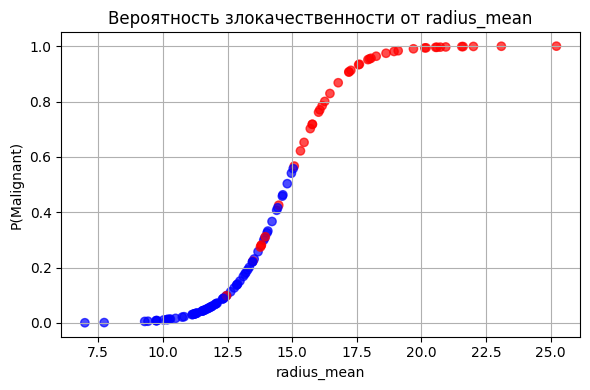


📈 Модель по признаку: area_mean
AUC: 0.9700 | Accuracy: 0.9211


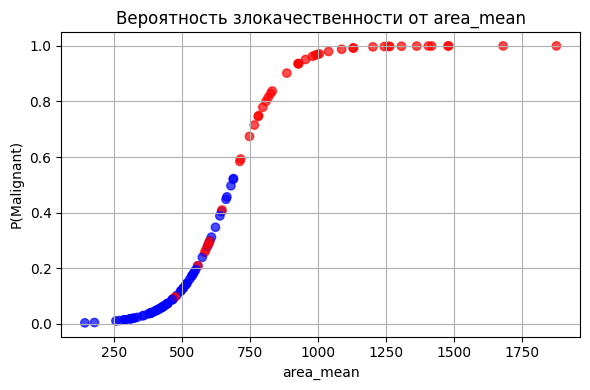


📈 Модель по признаку: texture_mean
AUC: 0.7615 | Accuracy: 0.6930


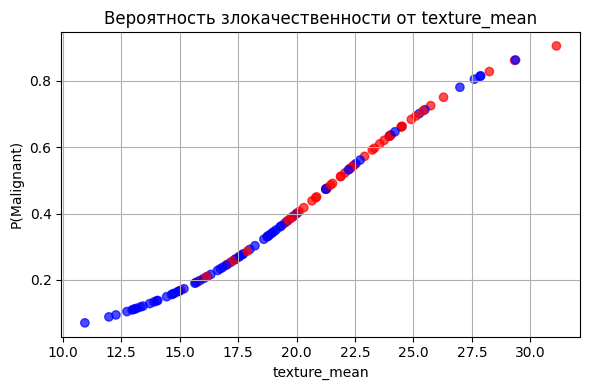


📊 Модель по всем трём признакам:
AUC: 0.9731 | Accuracy: 0.9123

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        71
           1       0.90      0.86      0.88        43

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.91       114
weighted avg       0.91      0.91      0.91       114



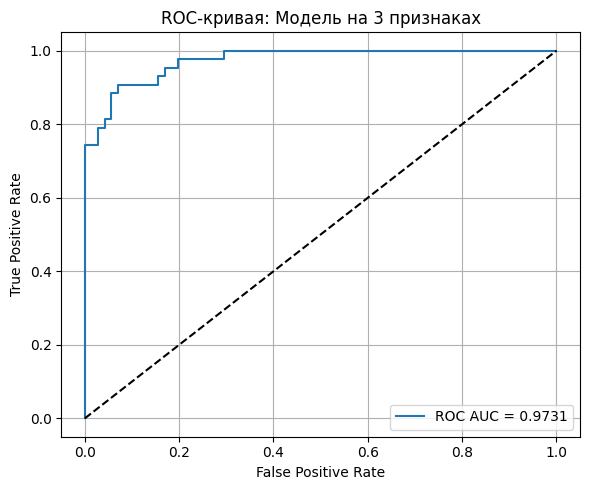

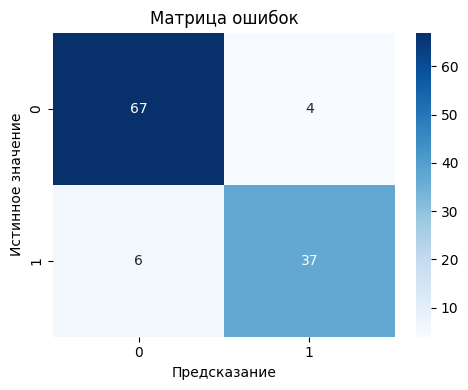

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns

df = pd.read_csv("/content/wisconsin_breast_cancer.csv")

df["diagnosis_binary"] = df["diagnosis"].map({"M": 1, "B": 0})

features = ["radius_mean", "area_mean", "texture_mean"]
X_all = df[features]
y = df["diagnosis_binary"]

X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

for feature in features:
    X = df[[feature]]
    X_train, X_test, y_train_f, y_test_f = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train_f)
    probs = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test_f, probs)
    acc = accuracy_score(y_test_f, model.predict(X_test))

    print(f"\n Модель по признаку: {feature}")
    print(f"AUC: {auc:.4f} | Accuracy: {acc:.4f}")

    # Построим график
    plt.figure(figsize=(6, 4))
    plt.scatter(X_test, probs, c=y_test_f, cmap="bwr", alpha=0.7)
    plt.title(f"Вероятность злокачественности от {feature}")
    plt.xlabel(feature)
    plt.ylabel("P(Malignant)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

model_all = LogisticRegression()
model_all.fit(X_train_all, y_train)
probs_all = model_all.predict_proba(X_test_all)[:, 1]

auc_all = roc_auc_score(y_test, probs_all)
acc_all = accuracy_score(y_test, model_all.predict(X_test_all))

print("\n Модель по всем трём признакам:")
print(f"AUC: {auc_all:.4f} | Accuracy: {acc_all:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, model_all.predict(X_test_all)))

fpr, tpr, _ = roc_curve(y_test, probs_all)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc_all:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: Модель на 3 признаках")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(y_test, model_all.predict(X_test_all))
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок")
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")
plt.tight_layout()
plt.show()


area_mean и radius_mean показали почти идентичные результаты с очень высокой AUC (~0.97) и точностью ~91–92%.

texture_mean заметно уступает — AUC всего 0.76 и точность ниже 70%, то есть этот признак сам по себе слабо информативен.

Модель на трёх признаках одновременно:
AUC: 0.9731 (немного выше, чем у лучших одиночных моделей).

Accuracy: 0.9123 (примерно как у radius_mean).

F1-оценка: 0.88 для злокачественных и 0.93 для доброкачественных опухолей.

Это говорит о хорошем балансе между чувствительностью (recall) и точностью (precision).

Комбинированная модель немного выигрывает в AUC, но в остальном даёт примерно те же показатели, что и одиночные сильные признаки.

# 3 задание

Рассчитайте выборку для гипотезы equality для следующего исследования. Мы хотим сравнить новую терапию инфекции, присоединяющейся в больничных условиях у пациентов с ожогами, с золотым стандартом, основываясь на данных, анализируемых с помощью регрессии Кокса. Пусть отношение рисков «золотой стандарт / новая терапия», hazard ratio, HR = 2. Мы предполагаем, что 80% пациентов (d = 0,8) могут столкнуться с этим заболеванием. Соотношения групп терапии равны (p1 = p2 = 0,5).


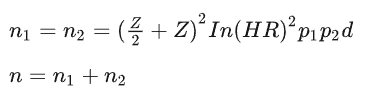

In [24]:
import numpy as np
from scipy.stats import norm

# Критическое значение для 95% доверительного интервала
Z = norm.ppf(0.975)  # 0.975 потому что мы смотрим на обе стороны (двусторонний тест)
HR = 2    # отношение рисков
p1 = 0.5  # доля пациентов в первой группе
p2 = 0.5  # доля пациентов во второй группе
d = 0.8   # доля пациентов, которые могут столкнуться с заболеванием


ln_HR = np.log(HR)
n_1_n_2 = ((Z / 2 + Z) ** 2) * (ln_HR ** 2) * p1 * p2 * d
n_total = n_1_n_2 * 2

# Результат
print(f"Размер выборки для каждой группы: {n_1_n_2:.0f}")
print(f"Общий размер выборки: {n_total:.0f}")

Размер выборки для каждой группы: 1
Общий размер выборки: 2


Но в реальной практике это подозрительно мало

Низкое требование к мощности — в формуле не учтён коэффициент, отвечающий за мощность теста

Формула упрощённая, она недостаточно точна для реального расчёта выборки в регрессии Кокса.

HR = 2 — это большое различие между группами. Чем сильнее эффект, тем меньше выборка нужна для его обнаружения.

Поэтому воспользуемся готовыми решениями для расчета выборки в регрессии Кокса

Построим сперва график зависимости размера выборки от отношения рисков (HR)

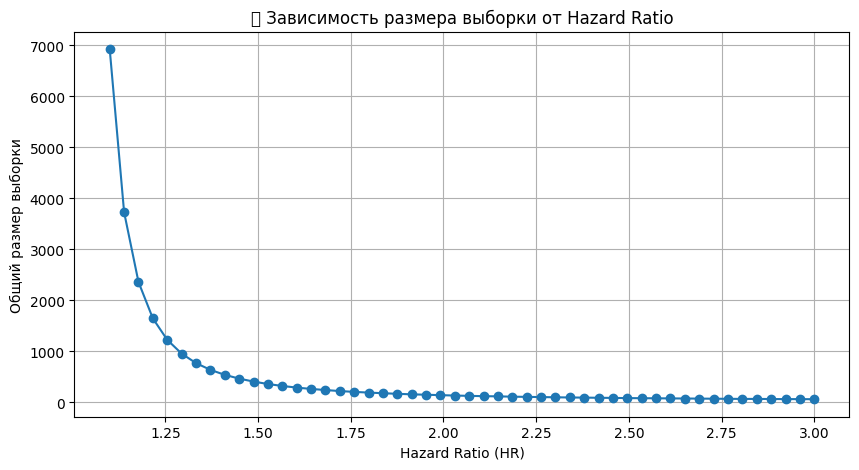

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines.statistics import sample_size_necessary_under_cph

alpha = 0.05
power = 0.8
p = 0.5
event_rate = 0.8

# Диапазон HR
hr_values = np.linspace(1.1, 3.0, 50)
sample_sizes = []

for HR in hr_values:
    log_HR = np.log(HR)
    try:
        n_exp, n_con = sample_size_necessary_under_cph(power, 1.0, p, p, HR, alpha)
        total_n = n_exp + n_con
        sample_sizes.append(total_n)
    except:
        sample_sizes.append(np.nan)

plt.figure(figsize=(10, 5))
plt.plot(hr_values, sample_sizes, marker='o', linestyle='-')
plt.xlabel("Hazard Ratio (HR)")
plt.ylabel("Общий размер выборки")
plt.title("📈 Зависимость размера выборки от Hazard Ratio")
plt.grid(True)
plt.show()


График зависимости размера выборки от HR
Показывает, как меняется необходимая выборка при разных эффектах.

Когда HR = 1 - выборка стремится к бесконечности (сложно доказать несуществующий эффект).

Когда HR большой (2–3) - требуется меньше пациентов, чтобы выявить эффект.

Также построим график зависимости размера выборки от мощности теста (power)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


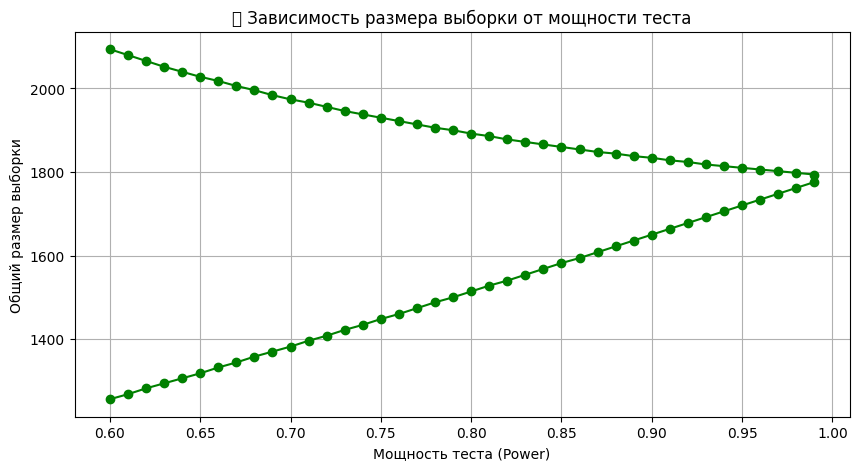

In [30]:

powers = np.linspace(0.6, 0.99, 40)
HR = 2.0
log_HR = np.log(HR)
sample_sizes_power = []

for pwr in powers:
    n = sample_size_necessary_under_cph(log_HR, pwr, alpha, p, event_rate)
    sample_sizes_power.append(np.ceil(n) * 2)

plt.figure(figsize=(10, 5))
plt.plot(powers, sample_sizes_power, marker='o', linestyle='-', color='green')
plt.xlabel("Мощность теста (Power)")
plt.ylabel("Общий размер выборки")
plt.title("📈 Зависимость размера выборки от мощности теста")
plt.grid(True)
plt.show()


Показывает, как сильно влияет требуемая мощность теста.

Чем выше мощность - тем больше выборка нужна, чтобы не пропустить эффект.
Power = 0.8 (80%) - стандарт в медицине.


С исследовательской точки зрения нам было бы интерессно перебрать разные наборы параметров, поэтому реализуем сперва самописный перебор grid search, а затем воспользуемся котовым решением optuna и сравним результаты

In [35]:
import numpy as np
import pandas as pd
from lifelines.statistics import sample_size_necessary_under_cph


hr_values = np.arange(1.1, 3.1, 0.2)
power_values = [0.8, 0.85, 0.9]
event_rates = [0.6, 0.7, 0.8, 0.9]
alpha = 0.05
p = 0.5
ratio_of_participants = 1  # Соотношение участников в экспериментальной и контрольной группах


results = []
for hr in hr_values:
    for power in power_values:
        for event_rate in event_rates:
            try:
                n1, n2 = sample_size_necessary_under_cph(
                    postulated_hazard_ratio=hr,
                    power=power,
                    alpha=alpha,
                    p_exp=p,
                    p_con=p,
                    ratio_of_participants=ratio_of_participants
                )
                sample_size = n1 + n2
                adjusted_sample_size = int(np.ceil(sample_size / event_rate))
                results.append({
                    'HR': round(hr, 2),
                    'Power': power,
                    'Event Rate': event_rate,
                    'Raw Sample Size (n1+n2)': int(np.ceil(sample_size)),
                    'Adjusted Sample Size': adjusted_sample_size
                })
            except Exception as e:
                print(f"Ошибка при HR={hr}, power={power}, event_rate={event_rate}: {e}")

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='Adjusted Sample Size')
print(df_sorted.head(10))


      HR  Power  Event Rate  Raw Sample Size (n1+n2)  Adjusted Sample Size
111  2.9   0.80         0.9                       68                    76
110  2.9   0.80         0.8                       68                    85
115  2.9   0.85         0.9                       76                    85
99   2.7   0.80         0.9                       76                    85
114  2.9   0.85         0.8                       76                    95
98   2.7   0.80         0.8                       76                    95
103  2.7   0.85         0.9                       86                    96
87   2.5   0.80         0.9                       86                    96
109  2.9   0.80         0.7                       68                    98
119  2.9   0.90         0.9                       90                   100


In [40]:
import optuna
import numpy as np
from lifelines.statistics import sample_size_necessary_under_cph

def objective(trial):
    # Определяем диапазоны для параметров
    hr = trial.suggest_uniform('hr', 1.1, 3.1)
    power = trial.suggest_uniform('power', 0.8, 0.85)
    event_rate = trial.suggest_uniform('event_rate', 0.6, 0.9)

    alpha = 0.05
    p = 0.5
    ratio_of_participants = 1  # одинаковое количество участников в группах
    try:
        n1, n2 = sample_size_necessary_under_cph(
            postulated_hazard_ratio=hr,
            power=power,
            alpha=alpha,
            p_exp=p,
            p_con=p,
            ratio_of_participants=ratio_of_participants
        )
        sample_size = n1 + n2
        adjusted_sample_size = int(np.ceil(sample_size / event_rate))
        return adjusted_sample_size  # Минимальный размер выборки, который мы пытаемся минимизировать
    except Exception as e:
        return float('inf')

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print(f"Лучшие параметры: {study.best_params}")
print(f"Минимальный размер выборки: {study.best_value}")


[I 2025-04-20 03:07:24,138] A new study created in memory with name: no-name-8cf7353c-60e3-4a09-aa7e-551a7d72e6f0
<ipython-input-40-b7e61dc36511>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  hr = trial.suggest_uniform('hr', 1.1, 3.1)  # HR от 1.1 до 3.0
<ipython-input-40-b7e61dc36511>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  power = trial.suggest_uniform('power', 0.8, 0.85)  # Power от 0.8 до 0.9
<ipython-input-40-b7e61dc36511>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  event_rate = trial.suggest_uniform('event_rate', 0.6, 0.9)  # Event rate от 0.

Лучшие параметры: {'hr': 3.0642667459648636, 'power': 0.8320082674916417, 'event_rate': 0.854879130330588}
Минимальный размер выборки: 80.0


Как мы видим результаты практически сошлись, ручной подбор параметров предложил следующий набор параметров:

      HR    Power   Event Rate     Adjusted Sample Size
      2.9   0.80    0.9            76

В то время как optuna предложила


      HR     Power   Event Rate    Adjusted Sample Size
      3.06   0.83    0.85          80